In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
#plotting and animation libraries
import matplotlib.pyplot as plt
import seaborn as sns
#clustering libraries
import scipy
import scipy.cluster as cl
import sklearn.cluster as skcl
import sklearn.metrics as skm
#pca library
import sklearn.decomposition as skd
import argparse
import datetime
import sys
sys.path.append('./segmentation_code/')
#My libraries
import LLSA as lvar
import LLSA_calculations as lvarc

/Users/antoniocosta/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the time series and the respective metadata 

In [2]:
tseries_path='./sample_data/Sample_tseries.h5'
f=h5py.File(tseries_path,'r')
thetas_gen=np.array(f['MetaData/thetas_gen'],dtype=np.float64)
frameRate=np.array(f['MetaData/FrameRate'])[0]
duration=np.array(f['MetaData/SimTime'])[0]
Ns=np.array(f['MetaData/NumSurrogates'],dtype=int)[0]
taus=np.sort(np.array(list(f.keys())[:-1],dtype=float))

tau=taus[0]
tseries_sim=[]
for iteration in range(1,Ns+1):
    f=h5py.File(tseries_path,'r')
    ts=np.array(f[str(tau)][str(iteration)]['tseries'],dtype=np.float64)
    tseries_sim.append(ma.array(ts))
f.close()

In [3]:
print('We have ',len(tseries_sim),' simulations created using thetas_gen.')

We have  100  simulations created using thetas_gen.


# Estimate the minimum window using the condition number

The condition number of the covariance matrix of the data and the error serves as guidance for choosing the minimum window size. It tells us when the least squares regression in well-conditioned, which corresponds to a drop in the condition number (high condition numbers indicate near-singularity)

In [4]:
guess_dims=4
range_minw=np.arange(guess_dims+1,6*guess_dims)
conds_sim=[]
conds_cov_sim=[]
n_windows_per_sim=100
for window in range_minw:
    conds=[]
    conds_cov=[]
    for sim_idx in range(len(tseries_sim)):
        tseries=tseries_sim[sim_idx]
        while len(conds)<n_windows_per_sim:
            start_t=np.random.randint(0,len(tseries))
            ts=tseries[start_t:start_t+window]
            if ma.count_masked(ts)==0 and len(ts)==window:
                conds.append(np.linalg.cond(np.cov(ts.T)))
                theta,eps=lvarc.get_theta(ts,1)
                inter,coef,cov=lvarc.decomposed_theta(theta)
                conds_cov.append(np.linalg.cond(cov)) 
    conds_sim.append(np.hstack(conds))
    conds_cov_sim.append(np.hstack(conds_cov))

In [5]:
def bootstrap(l,n_times,n_samples=1000,confidence_interval=95):
    if n_samples>len(l):
        n_samples=len(l)*2
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),n_samples)#len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.median(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return ma.median(l,axis=0),cil,ciu

In [6]:
median_sim=[]
median_cil_sim=[]
median_ciu_sim=[]
median_cov_sim=[]
median_cil_cov_sim=[]
median_ciu_cov_sim=[]
for k in range(len(conds_sim)):
    median,cil,ciu=bootstrap(conds_sim[k],100)
    median_sim.append(median)
    median_cil_sim.append(cil)
    median_ciu_sim.append(ciu)
    median,cil,ciu=bootstrap(conds_cov_sim[k],100)
    median_cov_sim.append(median)
    median_cil_cov_sim.append(cil)
    median_ciu_cov_sim.append(ciu)

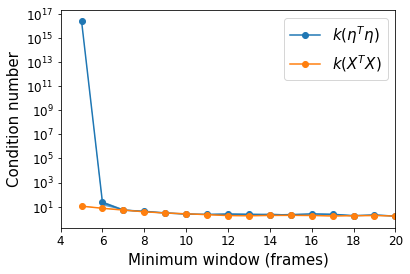

In [7]:
plt.plot(range_minw,np.hstack(median_cov_sim),marker='o',label='$k(\eta^T\eta)$')
plt.fill_between(range_minw,np.hstack(median_cil_cov_sim),np.hstack(median_ciu_cov_sim),alpha=.7)
plt.plot(range_minw,np.hstack(median_sim),marker='o',label='$k(X^TX)$')
plt.fill_between(range_minw,np.hstack(median_cil_sim),np.hstack(median_ciu_sim),alpha=.7)
plt.ylabel('Condition number',fontsize=15)
plt.xlabel('Minimum window (frames)',fontsize=15)
plt.yscale('log')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(guess_dims,20)
plt.legend(fontsize=15)
# plt.savefig('Cond_brain.eps')
plt.show()

Depending on the dimensionality of the system, the condition number might drop to a larger value. As a rule of thumb, for a d-dimensional time series is it reasonable to have a condition number of order 10^d.

In [8]:
#the value of w0 should be guided by the previous plot
w0=6
step_fraction=.1
i=w0
w=[]
while i < np.inf:
    w.append(i)
    step=int(i*step_fraction)
    if int(i*step_fraction)>w0:
        break
    if step<1:
        step=1
    i+=step

### Plot of a sample time series 

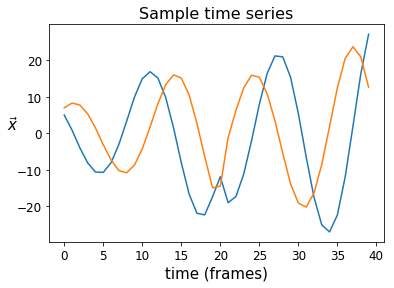

In [9]:
plt.title('Sample time series',fontsize=16)
plt.plot(tseries_sim[0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('time (frames)',fontsize=15)
plt.ylabel(r'$\vec{x}$',fontsize=15,rotation=0)
plt.show()

# Adaptive segmentation

In [10]:
N=1000
per=97.5
breaks_segments_sim=[]
#you can take this up to 100 (you can also parallelize this calculation) :)
num_tseries=5
for sim_idx in range(num_tseries):
    sample_tseries=tseries_sim[sim_idx]
    #apply segmentation algorithm
    breaks_segments=lvar.change_point(w,N,per,sample_tseries,20,cond_thresh=1e3)
    #cond_thresh is chosen in accordance to the condition number plot
    breaks_segments_sim.append(breaks_segments)

In [11]:
thetas_sim=[]
windows_sim=[]
for breaks_segments in breaks_segments_sim:
    windows_segment,segments=breaks_segments
    #compute thetas in the obtained windows_segment
    thetas_final=[]
    for idx,seg in enumerate(segments):
        segment_windows=np.copy(windows_segment[idx])
        segments_windows=list(segment_windows)
        thetas=[]
        for seg_w in segment_windows:
            i_0,i_f=seg_w
            window_bw=sample_tseries[i_0:i_f]
            theta,eps=lvarc.get_theta(window_bw,1)
            thetas.append(np.vstack(theta))
        thetas_final.append(thetas)
    thetas_final=np.concatenate(thetas_final)
    windows_final=np.concatenate(windows_segment)
    thetas_sim.append(thetas_final)
    windows_sim.append(windows_final)

In [12]:
#this raster plot is only interesting in the large n limit

raster=np.zeros((len(tseries_sim[0]),num_tseries))
for sim_idx,windows in enumerate(windows_sim):
    for window in windows:
        raster[window[1]-1,sim_idx]=1

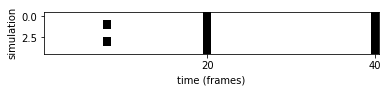

In [13]:
plt.imshow(raster.T,cmap='binary')
plt.xticks([19,39],['20','40'])
plt.xlabel('time (frames)')
plt.ylabel('simulation')
plt.show()

# Likelihood hierarchical clustering

In [14]:
def compute_master_theta(models,windows_sim,tseries_sim):
    master_tseries=[]
    for model in models:
        sim_idx,window_idx=model
        window=windows_sim[sim_idx][window_idx]
        t0,tf=window
        ts=tseries_sim[sim_idx][t0:tf]
        master_tseries.append(ts)
        master_tseries.append([np.nan]*ts.shape[1])
    master_tseries=ma.masked_invalid(ma.vstack(master_tseries))
    master_theta,eps=lvarc.get_theta_masked(master_tseries)
    return master_theta

def likelihood_distance(models,windows_sim,tseries_sim,thetas_sim):
    master_theta=compute_master_theta(models,windows_sim,tseries_sim)
    distances=[]
    for model in models:
        sim_idx,model_idx=model
        theta=thetas_sim[sim_idx][model_idx]
        window=windows_sim[sim_idx][model_idx]
        t0,tf=window
        ts=ma.masked_invalid(tseries_sim[sim_idx][t0:tf])
        theta_here,eps=lvarc.get_theta(ts)
        distances.append(lvarc.loglik_mvn_masked(theta,ts)-lvarc.loglik_mvn_masked(master_theta,ts))
    return np.sum(distances)

In [15]:
windows=windows_final
all_models=[]
for sim_idx in range(num_tseries):
    for kw,window in enumerate(windows_sim[sim_idx]):
        all_models.append([sim_idx,kw])
all_models=np.vstack(all_models)

## Compute dissimilarity matrix 

In [16]:
modelx_i=0
modelx_f=len(all_models)
modely_i=0
modely_f=len(all_models)


n_modelsx=modelx_f-modelx_i
n_modelsy=modely_f-modely_i
dissimilarity_matrix=np.zeros((n_modelsx,n_modelsy))
indices=np.array([[modelx_i,modelx_f],[modely_i,modely_f]])
for idx1,idx_model1 in enumerate(np.arange(modelx_i,modelx_f)):
    for idx2,idx_model2 in enumerate(np.arange(modely_i,modely_f)):
        model1=all_models[idx_model1]
        model2=all_models[idx_model2]
        models_=np.vstack((model1,model2))
        dist=likelihood_distance(models_,windows_sim,tseries_sim,thetas_sim)
        dissimilarity_matrix[idx1,idx2]=dist

### Ensure symmetrization before applying Ward's method 

In [17]:
def symmetrize(a):
    return (a + a.T)/2 - np.diag(a.diagonal())

In [18]:
#this fixes possible numerical precision errors
sym_dissimilarity_matrix=symmetrize(dissimilarity_matrix)
sym_dissimilarity_matrix[sym_dissimilarity_matrix<0]=0

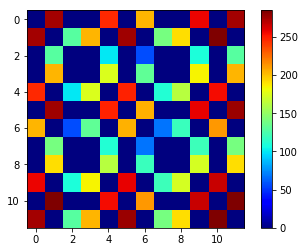

In [19]:
plt.imshow(sym_dissimilarity_matrix,cmap='jet')
plt.colorbar()
plt.show()

In [20]:
#load clustering packages
import scipy.cluster as cl
import scipy.spatial.distance as ssd

In [21]:
#turn distance matrix into a vector
pdist=ssd.squareform(sym_dissimilarity_matrix,force='tovector')
#perform hierarchical clustering using Ward's method
Z=cl.hierarchy.ward(pdist)

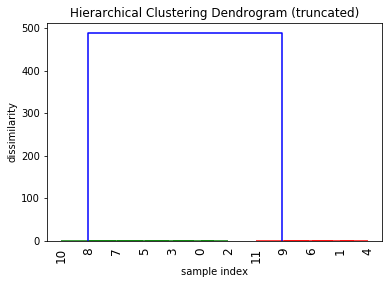

In [22]:
from scipy.cluster.hierarchy import dendrogram

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('dissimilarity')
ddgram=dendrogram(
    Z,
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
)
plt.grid(False)
plt.show()

#### Organize distance matrix according to the clustering

In [23]:
import scipy.cluster.hierarchy as sch
def seriation(Z,N,cur_index):
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,Z=0,method="ward",precomputed=False):
    N = len(dist_mat)
    if precomputed:
        res_linkage = Z
    else:
        flat_dist_mat = ssd.squareform(dist_mat)
        res_linkage=sch.linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

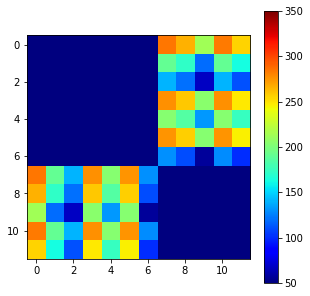

In [24]:
seriated_dist,res_order,res_linkage=compute_serial_matrix(sym_dissimilarity_matrix,Z=Z,precomputed=True)
plt.figure(figsize=(5,5))
plt.imshow(seriated_dist,cmap='jet',vmin=50,vmax=350)
plt.grid(False)
plt.colorbar()
plt.show()

In [25]:
from scipy.cluster.hierarchy import fcluster
# max_d = 2
# cluster_labels = fcluster(Z, max_d, criterion='distance')
k = 2
cluster_labels = fcluster(Z, k, criterion='maxclust')
cluster_labels

array([1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 1, 2], dtype=int32)

In [26]:
#you can get the frequency of the models used to simulate the data
freqs_gen=[]
coefs_gen=[]
for theta in thetas_gen:
    c,A,cov=lvarc.decomposed_theta(theta)
    coef=(A-np.identity(2))*frameRate
    coefs_gen.append(coef)
    eigs=np.linalg.eigvals(coef)
    freqs_gen.append(np.abs(eigs.imag[0])/(2*np.pi))

1
2


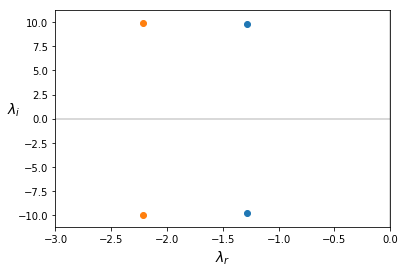

In [27]:
#and compare with the frequencies of the two main clusters
freqs=[]
coefs=[]
for idx in np.sort(np.unique(cluster_labels)):
    print(idx)
    indices=np.arange(len(cluster_labels))[cluster_labels==idx]
    master_theta=compute_master_theta(all_models[indices],windows_sim,tseries_sim)
    c,A,cov=lvarc.decomposed_theta(master_theta)
    coef=(A-np.identity(2))*frameRate
    coefs.append(coef)
    eigs=np.linalg.eigvals(coef)
    plt.scatter(eigs.real,eigs.imag)
    freqs.append(np.abs(eigs.imag[0])/(2*np.pi))
plt.xlim(-3,0)
plt.axvline(0,c='k',alpha=.2)
plt.axhline(0,c='k',alpha=.2)
plt.xlabel('$\lambda_r$',fontsize=14)
plt.ylabel('$\lambda_i$',fontsize=14,rotation=0)
plt.show()

In [28]:
freqs_gen

[1.5586625093313424, 1.5573618600959589]

In [29]:
freqs

[1.5591612958134593, 1.580036879850049]

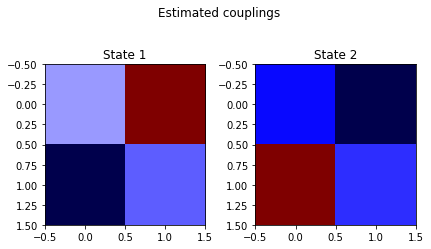

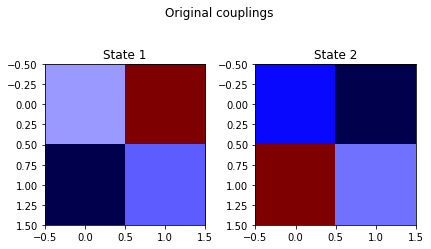

In [30]:
plt.suptitle('Estimated couplings')
for idx,coef in enumerate(coefs):
    plt.subplot(1,2,idx+1)
    plt.title('State '+str(idx+1))
    plt.imshow(coef,cmap='seismic',vmin=-5,vmax=5)
plt.tight_layout()
plt.show()
    
plt.suptitle('Original couplings')
for idx,coef in enumerate(coefs_gen):
    plt.subplot(1,2,idx+1)
    plt.title('State '+str(idx+1))
    plt.imshow(coef,cmap='seismic',vmin=-5,vmax=5)
plt.tight_layout()
plt.show()